In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install torch

In [1]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image

from models import RDN

import pandas as pd
import os

from utils import convert_rgb_to_y, denormalize, calc_psnr

In [70]:
def test(weights_file, image_file, num_features=64, growth_rate=64, num_blocks=16, num_layers=8, scale=4):
    cudnn.benchmark = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = RDN(scale_factor=scale,
                num_channels=3,
                num_features=num_features,
                growth_rate=growth_rate,
                num_blocks=num_blocks,
                num_layers=num_layers).to(device)

    state_dict = model.state_dict()
    for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)

    model.eval()

    image = pil_image.open(image_file).convert('RGB')

    image_width = (image.width // scale) * scale
    image_height = (image.height // scale) * scale

    hr = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
    lr = hr.resize((hr.width // scale, hr.height // scale), resample=pil_image.BICUBIC)
    bicubic = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
    bicubic.save(image_file.replace('.png', '_bicubic_x{}.png'.format(scale)))

    lr = np.expand_dims(np.array(lr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
    hr = np.expand_dims(np.array(hr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
    lr = torch.from_numpy(lr).to(device)
    hr = torch.from_numpy(hr).to(device)

    with torch.no_grad():
        preds = model(lr).squeeze(0)

    preds_y = convert_rgb_to_y(denormalize(preds), dim_order='chw')
    hr_y = convert_rgb_to_y(denormalize(hr.squeeze(0)), dim_order='chw')

    preds_y = preds_y[scale:-scale, scale:-scale]
    hr_y = hr_y[scale:-scale, scale:-scale]

    psnr = calc_psnr(hr_y, preds_y)
#     print('PSNR: {:.2f}'.format(psnr))

    output = pil_image.fromarray(denormalize(preds).permute(1, 2, 0).byte().cpu().numpy())
    output.save(image_file.replace('.png', '_rdn_x{}.png'.format(scale)))
    
    return {
        "test_set" : image_file.split("/")[1],
        "psnr" : psnr.item()
    }

In [3]:
models_dir = "../rdn-results/outputs/x4/"
images_dir = ["../BSDS100/", "../Set5/", "../Set14/", "../Urban100/"]

In [135]:
test_images = {}
for test_dir in images_dir:
    f = []
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        f.extend(filenames)
        break
    test_images[test_dir.split("/")[1]] = f

In [136]:
test_images

{'BSDS100': ['8023_bicubic_x4.png',
  '143090.png',
  '119082.png',
  '8023.png',
  '134035_rdn_x4.png',
  '134035.png',
  '302008.png',
  '296007.png',
  '304074.png',
  '304034.png',
  '119082_bicubic_x4.png',
  '160068.png',
  '145086.png',
  '69040.png',
  '143090_rdn_x4.png',
  '361010.png',
  '351093.png',
  '12084.png',
  '385039.png',
  '123074.png',
  '103070.png',
  '37073.png',
  '134035_bicubic_x4.png',
  '69020.png',
  '253027.png',
  '45096.png',
  '143090_bicubic_x4.png',
  '86068.png',
  '8023_rdn_x4.png',
  '78004.png',
  '109053.png',
  '87046.png',
  '97033.png',
  '38082.png',
  '241048.png',
  '42049.png',
  '33039.png',
  '41069.png',
  '260058.png',
  '210088.png',
  '105025.png',
  '197017.png',
  '299086.png',
  '157055.png',
  '167062.png',
  '219090.png',
  '296059.png',
  '89072.png',
  '66053.png',
  '291000.png',
  '76053.png',
  '163085.png',
  '108070.png',
  '227092.png',
  '208001.png',
  '55073.png',
  '119082_rdn_x4.png',
  '21077.png',
  '216081.png

In [137]:
five_up = {}
for i in test_images.keys():
    five_up[i] = test_images[i][:5]
five_up

{'BSDS100': ['8023_bicubic_x4.png',
  '143090.png',
  '119082.png',
  '8023.png',
  '134035_rdn_x4.png'],
 'Set14': ['baboon_bicubic_x4.png',
  'lenna.png',
  'baboon.png',
  'monarch.png',
  'coastguard.png'],
 'Set5': ['head.png',
  'bird_rdn_x4.png',
  'woman.png',
  'bird.png',
  'head_bicubic_x4.png'],
 'Urban100': ['img_051.png',
  'img_030_bicubic_x4.png',
  'img_030.png',
  'img_087.png',
  'img_008.png']}

In [138]:
pd.DataFrame(five_up)

,BSDS100,Set14,Set5,Urban100
0,8023_bicubic_x4.png,baboon_bicubic_x4.png,head.png,img_051.png
1,143090.png,lenna.png,bird_rdn_x4.png,img_030_bicubic_x4.png
2,119082.png,baboon.png,woman.png,img_030.png
3,8023.png,monarch.png,bird.png,img_087.png
4,134035_rdn_x4.png,coastguard.png,head_bicubic_x4.png,img_008.png


In [117]:
### get best model 
log_name = "base.log"
train_log = open("../rdn-results/logs/" + log_name)
train_log_arr = [i for i in train_log.read().split("\n") if i]

best_epoch = int(train_log_arr[-1].split(",")[0].split(":")[1])
train_log_arr[best_epoch]

'eval psnr: 30.08'

In [118]:
# display learning chart 

In [120]:
def create_dict_from_train_log(line):
    arr = line.split(":")
    
    return {arr[0] : float(arr[1])}
    

In [121]:
def process_train_loss_line(line):
    loss_arr = line.split("[")[-1].split(", ")[-1].replace("]", "").split("=")
    epoch = line.split(":")[1].split("/")[0]
    
    return {"epoch" : epoch, loss_arr[0] : float(loss_arr[1])}
    
    

### parse the training log copied from std output during training 

In [122]:
train_log_loss = open("../rdn-results/logs/training-loss.log")
train_log_loss_arr = [process_train_loss_line(i) for i in train_log_loss.read().split("\n") if "epoch" in i]
df_train_loss = pd.DataFrame(train_log_loss_arr)
df_train_loss.head()

,epoch,loss
0,0,0.078935
1,1,0.038575
2,2,0.036490
3,3,0.034232
4,4,0.032773


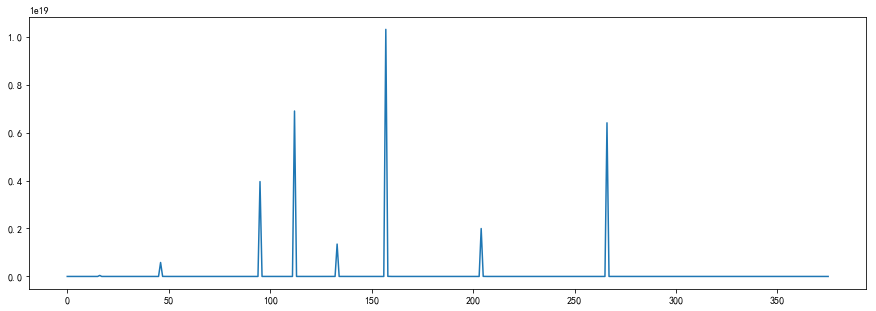

In [123]:
df_train_loss["loss"].plot(figsize=(15, 5))

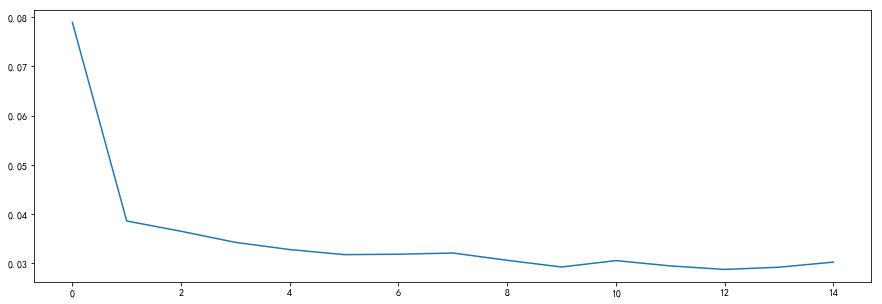

In [124]:
df_train_loss[df_train_loss["loss"] < 1.0]["loss"].plot(figsize=(15, 5))

In [125]:
train_log_dicts = [ create_dict_from_train_log(i) for i in train_log_arr[:-1]]

In [126]:
train_df = pd.DataFrame(train_log_dicts)
train_df.head()

,eval psnr
0,28.55
1,28.70
2,25.87
3,28.93
4,28.70


### progression of psnr across epochs

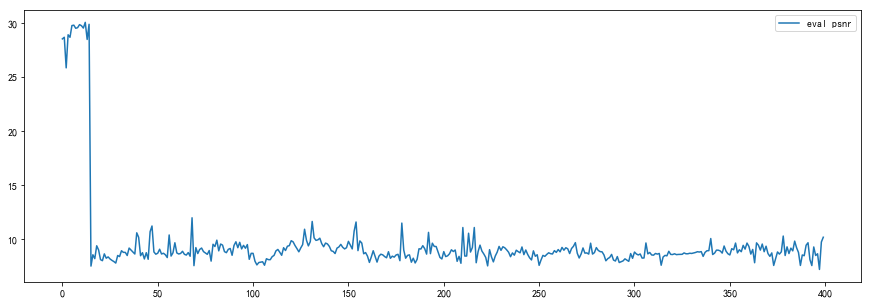

In [127]:
train_df.plot(figsize=(15, 5))

In [128]:
weights_file = models_dir + "best.pth"

os.path.isfile(weights_file), weights_file

(True, '../rdn-results/outputs/x4/best.pth')

In [141]:
test_results = []
if os.path.isfile(weights_file):
    for key in test_images.keys():
        max_images = 0
        print ("testing " + key)
        for image in test_images[key]:
            if not ("_rdn_x4" in image or "_bicubic_x" in image):
                image_file = "../" + key + "/" + image
                print("\t" +  image )
                test_results.append(test(weights_file, image_file))
            

testing BSDS100
	143090.png
	119082.png
	8023.png
	134035.png
	302008.png
	296007.png
	304074.png
	304034.png
	160068.png
	145086.png
	69040.png
	361010.png
	351093.png
	12084.png
	385039.png
	123074.png
	103070.png
	37073.png
	69020.png
	253027.png
	45096.png
	86068.png
	78004.png
	109053.png
	87046.png
	97033.png
	38082.png
	241048.png
	42049.png
	33039.png
	41069.png
	260058.png
	210088.png
	105025.png
	197017.png
	299086.png
	157055.png
	167062.png
	219090.png
	296059.png
	89072.png
	66053.png
	291000.png
	76053.png
	163085.png
	108070.png
	227092.png
	208001.png
	55073.png
	21077.png
	216081.png
	148026.png
	86000.png
	253055.png
	85048.png
	223061.png
	86016.png
	167083.png
	189080.png
	38092.png
	14037.png
	182053.png
	196073.png
	271035.png
	19021.png
	148089.png
	156065.png
	236037.png
	300091.png
	108005.png
	54082.png
	306005.png
	43074.png
	175043.png
	101085.png
	3096.png
	41033.png
	285079.png
	106024.png
	62096.png
	170057.png
	241004.png
	58060.png
	147091.png
	175032.p

In [155]:
def get_test_report(array_of_dicts, dataset):
    this_arr = [i for i in array_of_dicts if dataset == i["test_set"] ]
    return pd.DataFrame(this_arr)

In [149]:
import json 

with open("../rdn-results/logs/test-results.json", mode='w', encoding='utf-8') as f:
    json.dump(test_results, f)


In [156]:
stats_BSDS100 = get_test_report(test_results, "BSDS100")

In [157]:
stats_BSDS100["psnr"].describe()

count    100.000000
mean      28.076928
std        3.604416
min       21.012266
25%       25.659891
50%       27.732800
75%       30.242438
max       39.232224
Name: psnr, dtype: float64

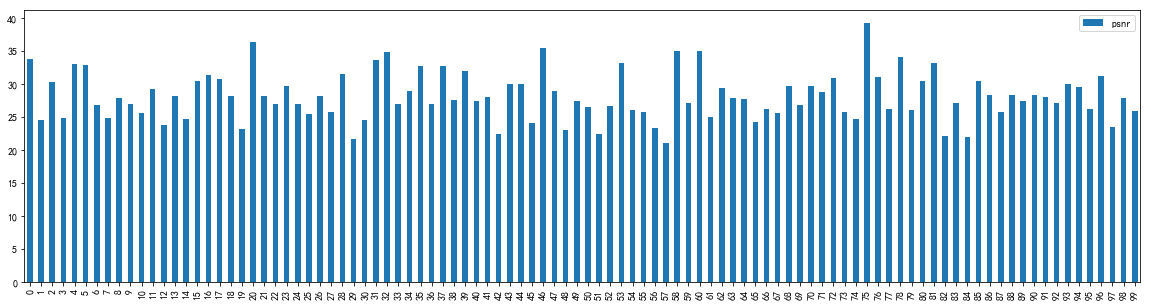

In [166]:
stats_BSDS100.plot.bar(figsize=(20,5))

In [167]:
stats_Set5 = get_test_report(test_results, "Set5")
stats_Set5.describe()

,psnr
count,5.000000
mean,31.183588
std,3.210761
min,26.182032
25%,29.753363
50%,32.827667
75%,33.503975
max,33.650902


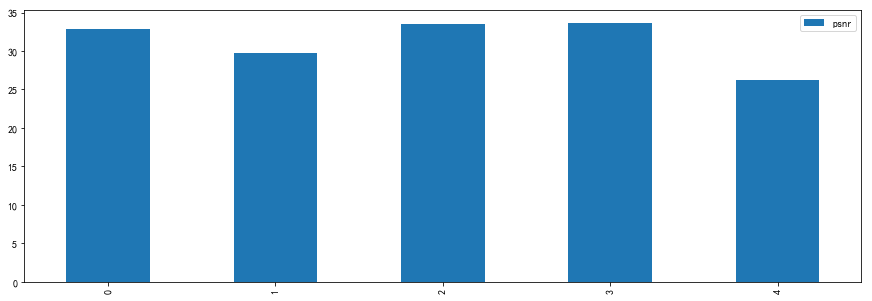

In [173]:
stats_Set5.plot.bar(figsize = (15,5))

In [169]:
stats_Set14 = get_test_report(test_results, "Set14")
stats_Set14.describe()

,psnr
count,14.000000
mean,28.151729
std,3.628098
min,22.903673
25%,25.705766
50%,27.242293
75%,31.736556
max,33.489777


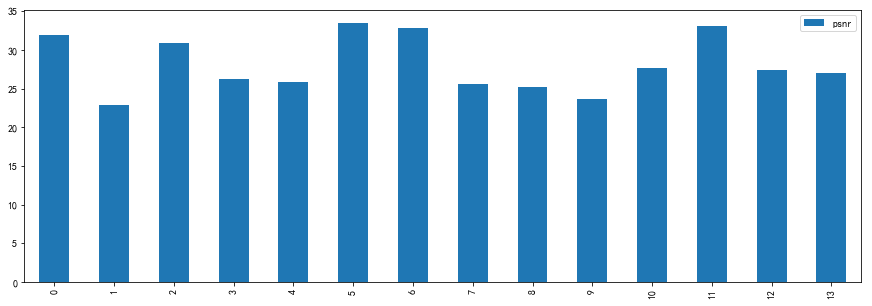

In [172]:
stats_Set14.plot.bar(figsize = (15,5))

In [174]:
stats_Urban100 = get_test_report(test_results, "Urban100")
stats_Urban100.describe()

,psnr
count,100.000000
mean,24.964593
std,3.703882
min,17.191830
25%,22.087560
50%,24.797892
75%,27.107933
max,34.862537


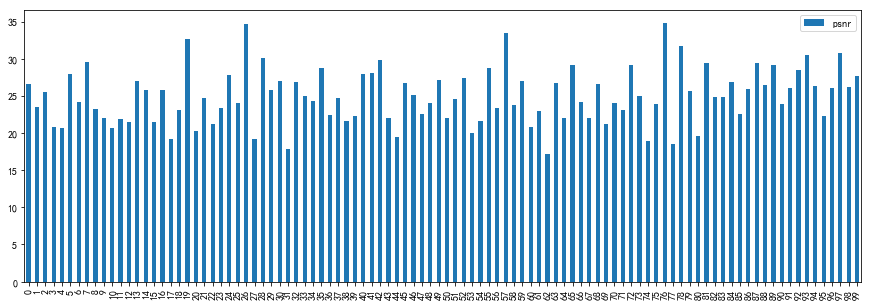

In [175]:
stats_Urban100.plot.bar(figsize = (15,5))